# L3b: Let's build a simple replay buffer
In this lab, we'll build a replay buffer that will allow a hypothetical planet exploration robot to store and replay its movements on a planet's surface using a coupled queue and stack.

> __Scenario:__ A surveyor robot is exploring the surface of a distant planet. As it moves, it records its starting position and the actions (moves) it takes at each time step. The robot can move in any of the four cardinal directions: north, south, east, or west. It can return to a previous position by reversing its last action. The robot needs a way to store its movements so that it can later replay them, either to retrace its steps to its home base, e.g., charging station, or to correct mistakes.

In this activity, we'll first generate a sequence of random movement commands and store them in a queue. Then, we will execute these commands while using a stack to track the robot's movement history for potential undo operations. Finally, we will visualize the complete path taken by our robotic explorer.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # what is this doing?

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
Let's define some constants that we will use throughout the activity. See the comment next to each constant for its meaning, permissible values, units, etc.

In [6]:
number_of_moves_per_episode = 100; # How many moves the robot will make in each episode
actions = Dict(1 => 'n', 2 => 's', 3 => 'e', 4 => 'w', 5 => 'p', 6 => 'b'); # The actions the robot can take: 1=north, 2=south, 3=east, 4=west, 5=pause, 6=back
moves = Dict('n' => (0, 1), 's' => (0, -1), 'e' => (1, 0), 'w' => (-1, 0), 'p' => (0, 0), 'b' => (0, 0)); # The moves the robot can make
starting_position = (0, 0); # The starting position of the robot (the grid position of the charging station)

___

## Task 1: Transmit the robot's movements to a queue
In this task, we generate a series of random movements for the robot and transmit them to a queue. From Earth, we send a vector of integers representing the actions the robot should take. The robot stores the corresponding characters in the queue. 

Let's generate a random sequence of commands for the robot to execute in the `commands_to_execute::Array{Int,1}` vector.

In [9]:
commands_to_execute = let

    # initialize - 
    commands = Array{Int,1}(undef, number_of_moves_per_episode);
    p = [0.30, 0.15, 0.15, 0.30, 0.10]; # The probabilities for actions 1-5 (n,s,e,w,p)
    d = Categorical(p); # The categorical distribution of the actions (excludes 'b' which is handled separately)
    θ = 0.10; # Fraction of the time we transmit a "back" command to the robot

    # generate a random command sequence -
    for i in 1:number_of_moves_per_episode
        if rand() < θ && i > 1 # if the random number is less than θ and not the first command
            commands[i] = 6; # back command
        else
            commands[i] = rand(d); # one of {n,s,e,w,pause} (actions 1-5) with probabilities defined in p
        end
    end

    commands; # return the commands
end

100-element Vector{Int64}:
 2
 6
 1
 4
 5
 4
 1
 1
 4
 4
 5
 5
 2
 ⋮
 6
 4
 2
 4
 1
 1
 1
 3
 1
 6
 6
 6

__Check:__ Let's check that the `commands_to_execute::Array{Int,1}` vector is valid, i.e., it has the correct length, contains only valid commands, and does not start with a `back` command.

There are a couple of ways to do this test. One is to use [the `@assert` macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check that our command sequence implementation produces valid output.

> __Alternative:__ When we have multiple tests to run, we can use [the `Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) to write __unit tests__ for our command sequence implementation. The [`Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) provides a framework for writing and running tests in Julia, including support for assertions, test cases, and test suites.

In this case, we can use [the `@testset` macro](https://docs.julialang.org/en/v1/stdlib/Test/#Test.@testset) to group our tests together and [the `@test` macro](https://docs.julialang.org/en/v1/stdlib/Test/#Test.@test) to check that the output of our command sequence implementation matches the expected output.

In [11]:
let
    @testset "Valid Command Sequence" begin
        @test commands_to_execute isa Array{Int,1}; # ensure commands_to_execute is an array of integers
        @test all(c -> c ∈ keys(actions), commands_to_execute); # ensure all commands are valid
        @test commands_to_execute[1] != 6; # ensure the first command is not a back command (should always pass due to our logic)
    end
end;

Test Summary:          | Pass  Total  Time
Valid Command Sequence |    3      3  0.3s


If all the tests pass, we can be confident that the `commands_to_execute::Array{Int,1}` vector is valid and ready to be transmitted to the robot. If a test fails, we need to regenerate the `commands_to_execute::Array{Int,1}` vector until all tests pass.

> __All tests have passed.__ So the commands stored in the `commands_to_execute::Array{Int,1}` have been transmitted to the robot! However, because the robot was built by different government subcontractors, the robot's software is not able to interpret the commands directly. Instead, we need to convert the commands to characters that the robot can understand. 

We'll then store these characters in the `command_queue::Queue{Char}`.

In [13]:
command_queue = let

    # initialize -
    q = Queue{Char}();
    for c ∈ commands_to_execute
        enqueue!(q, actions[c]); # convert the command to a character and push it to the queue
    end
    q; # return the queue
end

Queue{Char}(Deque [['s', 'b', 'n', 'w', 'p', 'w', 'n', 'n', 'w', 'w', 'p', 'p', 's', 's', 's', 'n', 'w', 'w', 'b', 'b', 's', 'n', 'n', 's', 'n', 'b', 'w', 'w', 's', 'e', 's', 'p', 'b', 'n', 'n', 'n', 's', 'w', 'b', 'n', 's', 'w', 'w', 'b', 'b', 'w', 'n', 'w', 'w', 'w', 'p', 'w', 'n', 'n', 'w', 'e', 'e', 's', 'w', 'w', 'w', 'e', 's', 'e', 'w', 'n', 'n', 'e', 'b', 'n', 'n', 'n', 'n', 'n', 'e', 'n', 'e', 'p', 'p', 'b', 'w', 'n', 'n', 'b', 'w', 's', 'b', 's', 'b', 'w', 's', 'w', 'n', 'n', 'n', 'e', 'n', 'b', 'b', 'b']])

___

## Task 2: Execute the commands in the queue
In this task, we will execute the commands in the `command_queue::Queue{Char}`. The robot will start at the `starting_position::Tuple{Int,Int}` and will execute the commands in the queue one by one. The robot will move in the direction specified by the command and will update its position accordingly. 

> __What happens if the robot gets a `back` command?__ The robot reverses its last action, moving back to the previous position or staying put if it's at the start. A `Stack{Char}` tracks commands to enable reversing, similar to undo/redo in many apps.

> __What happens if the robot gets a `pause` command?__ The `pause` command indicates that the robot should remain in its current position for a moment, effectively skipping any movement for that time step.

Before we proceed, consider the inverse of actions. If the robot moves north, a `back` command moves it south, returning to its previous position. Similarly, moving west can be reversed by moving east. We create a dictionary that maps actions to their inverses for easy reversal.

In [16]:
inverse_action = Dict('n' => 's', 's' => 'n', 'e' => 'w', 'w' => 'e', 'p' => 'p', 'b' => 'b'); # The inverse actions of the robot

Now we are ready to wander around the planet! We'll track the robot's position in the `robot_position_dict::Dict{Int64, Tuple{Int,Int}}` dictionary, where the key is the time index and the value is the robot's position at that time step.

In [18]:
robot_position_dict, executed_commands_dict = let

    # output -

    # initialize -
    robot_position = Dict{Int64, Tuple{Int,Int}}();
    executed_commands = Dict{Int64, Char}(); # dictionary to keep track of the robot's actions
    robot_position[0] = starting_position; # the robot starts at the charging station
    executed_commands[0] = 'p'; # the robot starts at the charging station, so it is paused
    undo = Stack{Char}(); # stack to keep track of the robot's last action
    counter = 1; # counter for the time step
    q = command_queue; # the command queue

    # execute the commands in the queue -
    while isempty(q) == false

        # get the current robot position
        xᵢ = robot_position[counter-1][1];
        yᵢ = robot_position[counter-1][2];
        
        # get the next command from the queue
        command = dequeue!(q); # get the next command from the queue

        # process the command to determine the action to take       
        action = nothing;
        if command == 'b' # if the command is a back command
            if isempty(undo) == false # if there is an action to undo
                last_action = pop!(undo); # get the last action from the stack
                action = inverse_action[last_action]; # get the inverse of the last action
                println("🔄 Back command at step $(counter): Undoing '$(last_action)' by executing '$(action)'");
            else
                # If no action to undo, treat as pause (robot can't go back from starting position)
                action = 'p';
                println("⏸️  Pause command at step $(counter): No actions to undo, pausing instead");
            end
        else
            action = command; # for all other commands, the action is the command itself
        end

        # Only push movement commands onto the undo stack (not 'b' or 'p')
        if action ∈ ['n', 's', 'e', 'w']
            push!(undo, action); # push the actual movement action to the stack
        end

        # execute the action
        Δ = moves[action]; # get the move associated with the action
        xᵢ += Δ[1]; # update the x position
        yᵢ += Δ[2]; # update the y position
        
        executed_commands[counter] = action; # update the executed commands dictionary
        robot_position[counter] = (xᵢ, yᵢ); # update the robot position in the dictionary
        counter += 1; # increment the time step counter
    end

    robot_position, executed_commands; # return the robot position and executed commands dictionaries
end;

🔄 Back command at step 2: Undoing 's' by executing 'n'
🔄 Back command at step 19: Undoing 'w' by executing 'e'
🔄 Back command at step 20: Undoing 'e' by executing 'w'
🔄 Back command at step 26: Undoing 'n' by executing 's'
🔄 Back command at step 33: Undoing 's' by executing 'n'
🔄 Back command at step 39: Undoing 'w' by executing 'e'
🔄 Back command at step 44: Undoing 'w' by executing 'e'
🔄 Back command at step 45: Undoing 'e' by executing 'w'
🔄 Back command at step 69: Undoing 'e' by executing 'w'
🔄 Back command at step 80: Undoing 'e' by executing 'w'
🔄 Back command at step 84: Undoing 'n' by executing 's'
🔄 Back command at step 87: Undoing 's' by executing 'n'
🔄 Back command at step 89: Undoing 's' by executing 'n'
🔄 Back command at step 98: Undoing 'n' by executing 's'
🔄 Back command at step 99: Undoing 's' by executing 'n'
🔄 Back command at step 100: Undoing 'n' by executing 's'


### Visualize the robot's movements
Finally, we'll visualize the robot's movements on a grid. We'll use the `robot_position_dict::Dict{Int64, Tuple{Int,Int}}` dictionary to plot the robot's position at each time step. The robot's starting position will be marked with a green circle, and the robot's final position will be marked with a red circle. The robot's path will be shown as a blue line connecting the positions at each time step.

We have the option to save each frame of the robot's movements as an image for further analysis or animation.

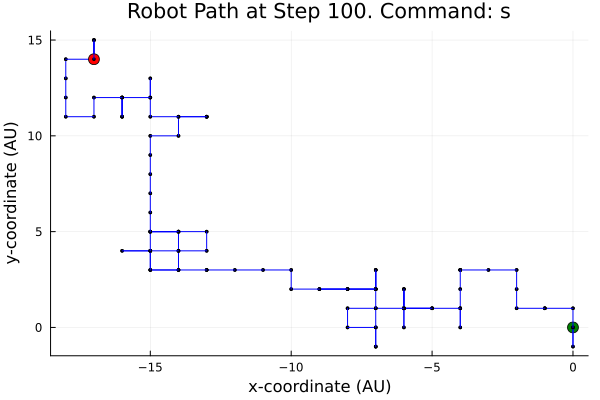

In [20]:
let

    # initialize -
    number_of_steps = length(robot_position_dict);
    should_save_image_every_step = false; # whether to save an image for every step

    for i ∈ 1:(number_of_steps - 1)
        x₁, y₁ = robot_position_dict[i - 1]; # get the robot position at time step i
        x₂, y₂ = robot_position_dict[i]; # get the robot position at time step i + 1
        command = executed_commands_dict[i]; # get the command executed at time step i
        
        if i == 1
            scatter([x₁], [y₁], color = :green, markersize = 6, label=""); # plot the starting position
        elseif i == (number_of_steps - 1)
            scatter!([x₂], [y₂], color = :red, markersize = 6, label=""); # plot the final position
        end
        
        scatter!([x₁, x₂], [y₁, y₂], # plot the robot positions
            color = :black, markersize = 2, label=""); # plot the robot positions
        plot!([x₁, x₂], [y₁, y₂],  # plot the line between the two positions
            color = :blue, linewidth = 1, label=""); # plot the robot path

        Plots.title!("Robot Path at Step $(i). Command: $(command)"); # set the title of the plot

        if should_save_image_every_step == true
            Plots.savefig(joinpath(_PATH_TO_SIMS, "robot_path_step_$(i).png")); # save the image for the current step
        end

    end

    Plots.xlabel!("x-coordinate (AU)", fontsize=18);
    Plots.ylabel!("y-coordinate (AU)", fontsize=18);
    
    current();
end

## Summary

In this activity, we explored how queues and stacks work together to create a replay buffer system for robotic navigation. We generated random movement commands and stored them in a queue following first-in-first-out principles. This simulates mission control sending navigation instructions that are processed sequentially.

We implemented undo functionality using a stack's last-in-first-out principle to track movement history. When the robot receives a "back" command, it retrieves its most recent movement and executes the inverse action. This is similar to undo features in software applications.

Our robust implementation only tracked actual movement commands on the stack, preventing confusion from undoing undo operations. The visualization demonstrated how combining queued commands with stack-based history creates powerful systems for navigation and error correction. This pattern appears in many real-world applications from web browsers to video games.